In [1]:
#|hide
from fastrl.test_utils import initialize_notebook
initialize_notebook()

In [2]:
#|default_exp memory.advantage_buffer

In [3]:
#|export
# Python native modules
from typing import NamedTuple,Dict,Literal,List,Union,Tuple
# Third party libs
import torch
from torch import nn
import torchdata.datapipes as dp 
from torchdata.dataloader2.graph import DataPipe
from fastrl.torch_core import evaluating
from fastcore.all import add_docs,ifnone
from tensordict import tensorclass
# Local modules
from fastrl.core import StepTypes,add_dataclass_doc,SimpleStep

# Advantage Buffer

In [4]:
#|export
@tensorclass
class AdvantageStep:
    state:          torch.FloatTensor = None
    action:         torch.FloatTensor = None
    next_state:     torch.FloatTensor = None
    terminated:     torch.BoolTensor  = None
    truncated:      torch.BoolTensor  = None
    reward:         torch.FloatTensor = None
    total_reward:   torch.FloatTensor = None
    env_id:         torch.LongTensor  = None
    proc_id:        torch.LongTensor  = None
    step_n:         torch.LongTensor  = None
    episode_n:      torch.LongTensor  = None
    image:          torch.FloatTensor = None
    raw_action:     torch.FloatTensor = None
    advantage:      torch.FloatTensor = None
    next_advantage: torch.FloatTensor = None

    def __post_init__(self):
        self.state          = ifnone(self.state,          torch.zeros(self.batch_size).to(torch.float32))
        self.action         = ifnone(self.action,         torch.zeros(self.batch_size).to(torch.float32))
        self.next_state     = ifnone(self.next_state,     torch.zeros(self.batch_size).to(torch.float32))
        self.terminated     = ifnone(self.terminated,     torch.zeros(self.batch_size).to(torch.bool))
        self.truncated      = ifnone(self.truncated,      torch.zeros(self.batch_size).to(torch.bool))
        self.reward         = ifnone(self.reward,         torch.zeros(self.batch_size).to(torch.long))
        self.total_reward   = ifnone(self.total_reward,   torch.zeros(self.batch_size).to(torch.float32))
        self.env_id         = ifnone(self.env_id,         torch.zeros(self.batch_size).to(torch.long))
        self.proc_id        = ifnone(self.proc_id,        torch.zeros(self.batch_size).to(torch.long))
        self.step_n         = ifnone(self.step_n,         torch.zeros(self.batch_size).to(torch.long))
        self.episode_n      = ifnone(self.episode_n,      torch.zeros(self.batch_size).to(torch.long))
        self.image          = ifnone(self.image,          torch.zeros(self.batch_size).to(torch.float32))
        self.raw_action     = ifnone(self.raw_action,     torch.zeros(self.batch_size).to(torch.float32))
        self.advantage      = ifnone(self.advantage,      torch.zeros(self.batch_size).to(torch.float32))
        self.next_advantage = ifnone(self.next_advantage, torch.zeros(self.batch_size).to(torch.float32))


    @classmethod
    def random(cls,batch_size,**flds):
        "Returns `cls` with all fields not defined in `flds` with `batch_size`"
        self = cls(batch_size=batch_size,**flds)
        d = self._tensordict
        for k,v in d.items():
            if k in flds:
                continue
            if isinstance(v,torch.BoolTensor):
                v.random_(0,1)
            else:
                v.random_(0,100)
        return self

StepTypes.register(AdvantageStep)

add_dataclass_doc(
AdvantageStep,
"""Represents a single step in an environment similar to `SimpleStep` however has
an addition field called `advantage`.""",
advantage="Generally characterized as $A(s,a) = Q(s,a) - V(s)$",
next_advantage="Generally characterized as $A(s,a) = Q(s,a) + V(s)$",
**{k:v.metadata for k,v in SimpleStep.__dataclass_fields__.items()}
)

In [5]:
#|export
@torch.jit.script
def discounted_cumsum_(t:torch.Tensor,gamma:float,reverse:bool=False):
    """Performs a cumulative sum on `t` where `gamma` is applied for each index
    >1."""
    if reverse:
        # We do +2 because +1 is needed to avoid out of index t[idx], and +2 is needed
        # to avoid out of index for t[idx+1].
        for idx in range(t.size(0)-2,-1,-1):
            t[idx] = t[idx] + t[idx+1] * gamma
    else:
        for idx in range(1,t.size(0)):
            t[idx] = t[idx] + t[idx-1] * gamma

In [6]:
#|export
class AdvantageBuffer(dp.iter.IterDataPipe):
    debug=False
    def __init__(self,
            # A datapipe that produces `StepType`s.
            source_datapipe:DataPipe,
            # A model that takes in a `state` and outputs a single value 
            # representing $V$, where as $Q$ is $V + reward$
            critic:nn.Module,
            # Will accumulate up to `bs` or when the episode has terminated.
            bs=1000,
            # The discount factor, otherwise known as $\gamma$, is defined in 
            # (Shulman et al., 2016) as '... $\gamma$ introduces bias into
            # the policy gradient estimate...'.
            discount:float=0.99,
            # $\lambda$ is unqiue to GAE and manages importance to values when 
            # they are in accurate is defined in (Shulman et al., 2016) as '... $\lambda$ < 1
            # introduces bias only when the value function is inaccurate....'.
            gamma:float=0.99,
            nsteps:int = 1
        ):
        self.source_datapipe = source_datapipe
        self.bs = bs
        self.critic = critic
        self.device = None
        self.discount = discount
        self.nsteps = nsteps
        self.gamma = gamma
        self.env_advantage_buffer:Dict[Literal['env'],list] = {}

    def to(self,*args,**kwargs):
        self.device = kwargs.get('device',None)

    def __repr__(self):
        return str({k:v if k!='env_advantage_buffer' else f'{len(self)} elements' 
                    for k,v in self.__dict__.items()})

    def __len__(self): return self._sz_tracker

    def update_advantage_buffer(self,step:StepTypes.types) -> int:
        if self.debug: 
            print('Adding to advantage buffer: ',step)
        env_id = int(step.env_id.detach().cpu())
        if env_id not in self.env_advantage_buffer: 
            self.env_advantage_buffer[env_id] = []
        self.env_advantage_buffer[env_id].append(step)
        return env_id
        
    def zip_steps(
        self,steps:List[Union[StepTypes.types]]
    ) -> Tuple[torch.FloatTensor,torch.FloatTensor,torch.BoolTensor]:
        step_subset = [(o.reward,o.state,o.truncated or o.terminated) for o in steps]
        zipped_fields = zip(*step_subset)
        return list(map(torch.vstack,zipped_fields))

    def delta_calc(self,reward,v,v_next,done):
        return reward + (self.gamma * v * done) - v_next

    def __iter__(self) -> AdvantageStep:
        self.env_advantage_buffer:Dict[Literal['env'],list] = {}
        for step in self.source_datapipe:
            env_id = self.update_advantage_buffer(step)
            done = step.truncated or step.terminated
            if done or len(self.env_advantage_buffer[env_id])>self.bs:
                steps = self.env_advantage_buffer[env_id]
                rewards,states,dones = self.zip_steps(steps)
                # We vstack the final next_state so we have a complete picture
                # of the state transitions and matching reward/done shapes.
                with torch.no_grad():
                    with evaluating(self.critic):
                        values = self.critic(torch.vstack((states,steps[-1].next_state)))
                delta = self.delta_calc(rewards,values[:-1],values[1:],dones)
                discounted_cumsum_(delta,self.discount*self.gamma**self.nsteps,reverse=True)

                for _step,gae_advantage,v in zip(*(steps,delta,values)):
                    yield AdvantageStep(
                        advantage=gae_advantage,
                        next_advantage=gae_advantage+v,
                        **{f:getattr(_step,f) for f in _step.__dataclass_fields__},
                        batch_size=[]
                    )
                self.env_advantage_buffer[env_id].clear()

add_docs(
AdvantageBuffer,
"""Collects an entire episode, calculates the advantage for each step, then
yields that episode's `AdvantageStep`s.

This is described in the original paper `(Shulman et al., 2016) High-Dimensional 
Continuous Control Usin Generalized Advantage Estimation`.

This algorithm is based on the concept of advantage:

$A_{\pi}(s,a) = Q_{\pi}(s,a) - V_{\pi}(s)$

Where (Shulman et al., 2016) pg 5 calculates it as:

$\hat{A}_{t}^{GAE(\gamma,\lambda)} = \sum_{l=0}^{\infty}(\gamma\lambda)^l\delta_{t+l}^V$

Where (Shulman et al., 2016) pg 4 defines $\delta$ as:

$\delta_t^V = r_t + \gamma V(s_{t+1}) - V(s_{t})$
""",
to=torch.Tensor.to.__doc__,
update_advantage_buffer="Adds `step` to `env_advantage_buffer` based on the environment id.",
zip_steps="""Given `steps`, strip out the `Tuple[reward,state,truncated or terminated]` fields,
and `torch.vstack` them.""",
delta_calc="""Calculates $\delta_t^V = r_t + \gamma V(s_{t+1}) - V(s_{t})$ which 
is the advantage difference between state transitions."""
)

In [7]:
from fastcore.all import test_eq
import gymnasium as gym
import fastrl.pipes.iter.cacheholder
from fastrl.layers import Critic
from fastrl.envs.gym import GymStepper
from functools import partial
import fastrl.envs.continuous_debug_env

In [8]:
def test_pipe(source,critic,adv_bs=16):
    pipe = dp.iter.IterableWrapper(source)
    pipe = pipe.map(partial(gym.make,max_episode_steps=400,goal_position=300))
    pipe = pipe.pickleable_in_memory_cache()
    pipe = pipe.cycle() 
    pipe = GymStepper(pipe,agent=None,seed=0)
    pipe = AdvantageBuffer(pipe,critic=critic,bs=adv_bs)
    pipe = pipe.batch(1)
    return pipe.header(400)

critic = Critic(1,0)

gym_pipe = test_pipe(['fastrl/ContinuousDebugEnv-v0'],critic=critic)

steps = []
for chunk in gym_pipe:
    for step in chunk:
        steps.append(step)
        test_eq(type(step),AdvantageStep)
        assert step.advantage!=0

In [9]:
import matplotlib.pyplot as plt

In [13]:
def normalize(data):
    mean = sum(data) / len(data)
    variance = sum([(x - mean) ** 2 for x in data]) / len(data)
    stddev = variance ** 0.5
    return [(x - mean) / stddev for x in data]


def visualize_advantage_steps(steps: [AdvantageStep]):
    # Extract relevant data from steps
    rewards = [step.reward.item() for step in steps]
    advantages = [step.advantage.item() for step in steps]
    next_advantages = [step.next_advantage.item() for step in steps]
    action = [step.action.item() for step in steps]
    critic_values = [na - a for na, a in zip(next_advantages, advantages)]

    # Normalize the data
    rewards = normalize(rewards)
    advantages = normalize(advantages)
    action = normalize(action)
    next_advantages = normalize(next_advantages)
    critic_values = normalize(critic_values)


    # Plot the data
    fig, ax = plt.subplots(figsize=(12, 6))

    # ax.plot(rewards, label="Rewards", color="blue")
    ax.plot(advantages, label="Advantages", color="green")
    # ax.plot(next_advantages, label="Next Advantages", color="red")
    ax.plot(critic_values, label="Critic Value Estimates", color="purple")
    # ax.plot(action, label="Action Value Estimates", color="orange")
    
    ax.set_xlabel("Steps")
    ax.set_ylabel("Value")
    ax.set_title("Visualization of Advantage Steps")
    ax.legend()

    plt.show()

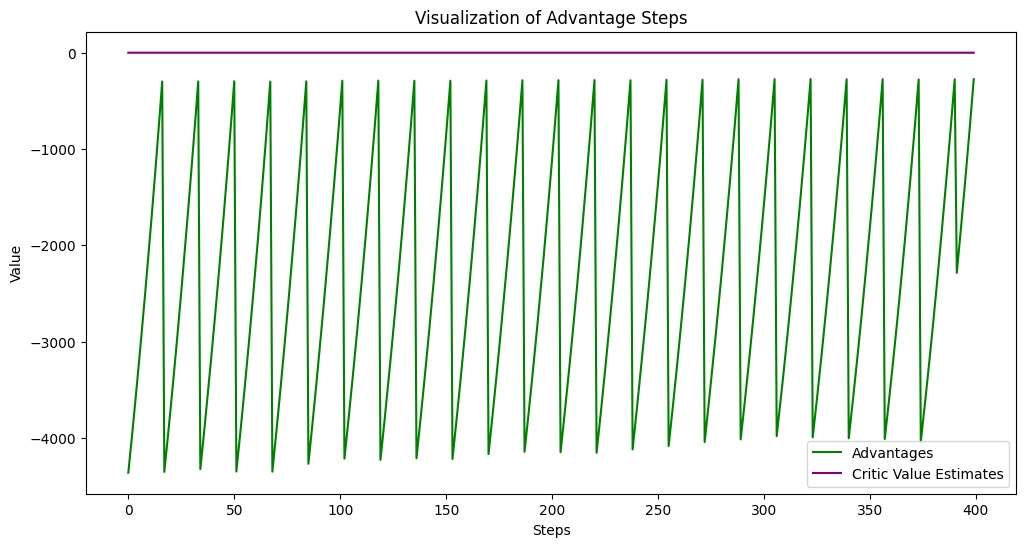

In [14]:
visualize_advantage_steps(steps)

In [12]:
#|hide
#|eval: false
!nbdev_export